### **Motor de Recomendación Simple**

In [1]:
import pandas as pd

# 1. Cargamos tus leads clasificados (los 152 de Oro)
df_leads = pd.read_parquet('../users_with_target_week1.parquet')

# 2. Cargamos el catálogo de caballos que ya limpiaron tus compañeros
df_caballos = pd.read_parquet('../equinenow_horses_listings_limpio.parquet')

print("✅ ¡Conexión exitosa!")
print(f"Tienes {len(df_leads)} usuarios listos y {len(df_caballos)} caballos para ofrecer.")

✅ ¡Conexión exitosa!
Tienes 200000 usuarios listos y 1905 caballos para ofrecer.


In [3]:
def motor_recomendacion_simple(row):
    # Definimos el nombre correcto de la columna que lanzaba error
    col_p = 'Price' 
    
    # Regla para Lead ORO: Recomendamos los caballos más caros (Top 3)
    if row['target_lead'] == 'Oro':
        top_caballos = df_caballos.nlargest(3, col_p)['Name'].tolist()
        return f"VIP: Te recomendamos estos ejemplares exclusivos: {', '.join(top_caballos)}"
    
    # Regla para Lead PLATA: Recomendamos caballos de precio medio
    elif row['target_lead'] == 'Plata':
        # Filtramos y tomamos los primeros 3 que cumplan el rango
        filtro_plata = df_caballos[(df_caballos[col_p] > 10000) & (df_caballos[col_p] <= 50000)]
        medio_caballos = filtro_plata.head(3)['Name'].tolist()
        return f"Calidad: Mira estos caballos para tu nivel: {', '.join(medio_caballos)}"
    
    # Regla para INTERESADOS (y Bronce si apareciera): Los más económicos
    else:
        barato_caballos = df_caballos.nsmallest(3, col_p)['Name'].tolist()
        return f"Inicio: Empieza tu aventura con: {', '.join(barato_caballos)}"

# 1. Ejecutamos el motor con una muestra de 10
df_muestra = df_leads.sample(10) 
df_muestra['recomendacion'] = df_muestra.apply(motor_recomendacion_simple, axis=1)

# 2. Mostramos los resultados de los caballos
print("--- RECOMENDACIONES DE CABALLOS ---")
display(df_muestra[['target_lead', 'recomendacion']])

# 3. Agregamos lo de los productos (Accesorios)
print("\n--- RECOMENDACIONES DE PRODUCTOS ---")
df_productos = pd.read_parquet('../doversaddlery_products_listing_limpio.parquet')
accesorios = df_productos.head(3)['Name'].tolist()
print(f"🛍️ Además, para tu nuevo equipo te sugerimos: {', '.join(accesorios)}")

--- RECOMENDACIONES DE CABALLOS ---


,target_lead,recomendacion
28263,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
71906,Plata,Calidad: Mira estos caballos para tu nivel: ba...
118924,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
91789,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
175202,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
17016,Plata,Calidad: Mira estos caballos para tu nivel: ba...
48681,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
23336,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
15003,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."
20387,Interesado,"Inicio: Empieza tu aventura con: vinnie, rosie..."



--- RECOMENDACIONES DE PRODUCTOS ---
🛍️ Además, para tu nuevo equipo te sugerimos: troxel® sport 2.0™ helmet, weatherbeeta® free standard neck turnout sheet, rider’s international™ laced rein dog collar


### **Modelo**

#### 1. Limpiezade Nombres

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# 1. Hacemos una copia para trabajar seguro 
df_limpio = df_caballos.copy()

# 2. Si el nombre es 'Unknown' o no hay nada, le ponemos 'No Name'
df_limpio['Name'] = df_limpio['Name'].astype(str).replace(['Unknown', 'unknown', 'None', 'nan'], 'No Name')

# 3. Hacemos lo mismo con Raza y Color
df_limpio['Breed'] = df_limpio['Breed'].fillna('Not Specified')
df_limpio['Color'] = df_limpio['Color'].fillna('Not Specified')

print("✅ Paso 1: Nombres y categorías limpios.")

✅ Paso 1: Nombres y categorías limpios.


#### 2. Crear los números (Las 126 columnas)

In [38]:
# 1. Elegimos qué mirar del caballo
columnas_interes = ['Breed', 'Gender', 'Color']
df_features = pd.get_dummies(df_limpio[columnas_interes], columns=columnas_interes)

# 2. Agregamos Precio y Edad (y rellenamos vacíos con 0)
df_features['Price'] = pd.to_numeric(df_limpio['Price'], errors='coerce').fillna(0)
df_features['Age'] = pd.to_numeric(df_limpio['Age'], errors='coerce').fillna(0)

# 3. EL TRUCO PARA QUE NO SE REPITAN:
# Agregamos un número pequeñito aleatorio a cada dato. 
# Así, aunque dos caballos sean 'No Name' y cuesten 0, serán un poquito diferentes para la IA.
np.random.seed(42)
ruido = np.random.normal(0, 0.0001, df_features.shape)
df_features_unicos = df_features + ruido

# 4. Achicamos todo al rango 0-1 (Escalado)
scaler = MinMaxScaler()
matriz_matematica = scaler.fit_transform(df_features_unicos)

print(f"✅ Paso 2: Matriz lista con {df_features_unicos.shape[1]} columnas únicas.")

✅ Paso 2: Matriz lista con 126 columnas únicas.


#### 3. Entrenar el Modelo (El Buscador)

In [39]:
# Creamos el buscador usando Similitud de Coseno
modelo_ia = NearestNeighbors(n_neighbors=5, metric='cosine')
modelo_ia.fit(matriz_matematica)

print("✅ Paso 3: El modelo KNN ha sido entrenado.")

✅ Paso 3: El modelo KNN ha sido entrenado.


#### 4. Mapa de Calor 

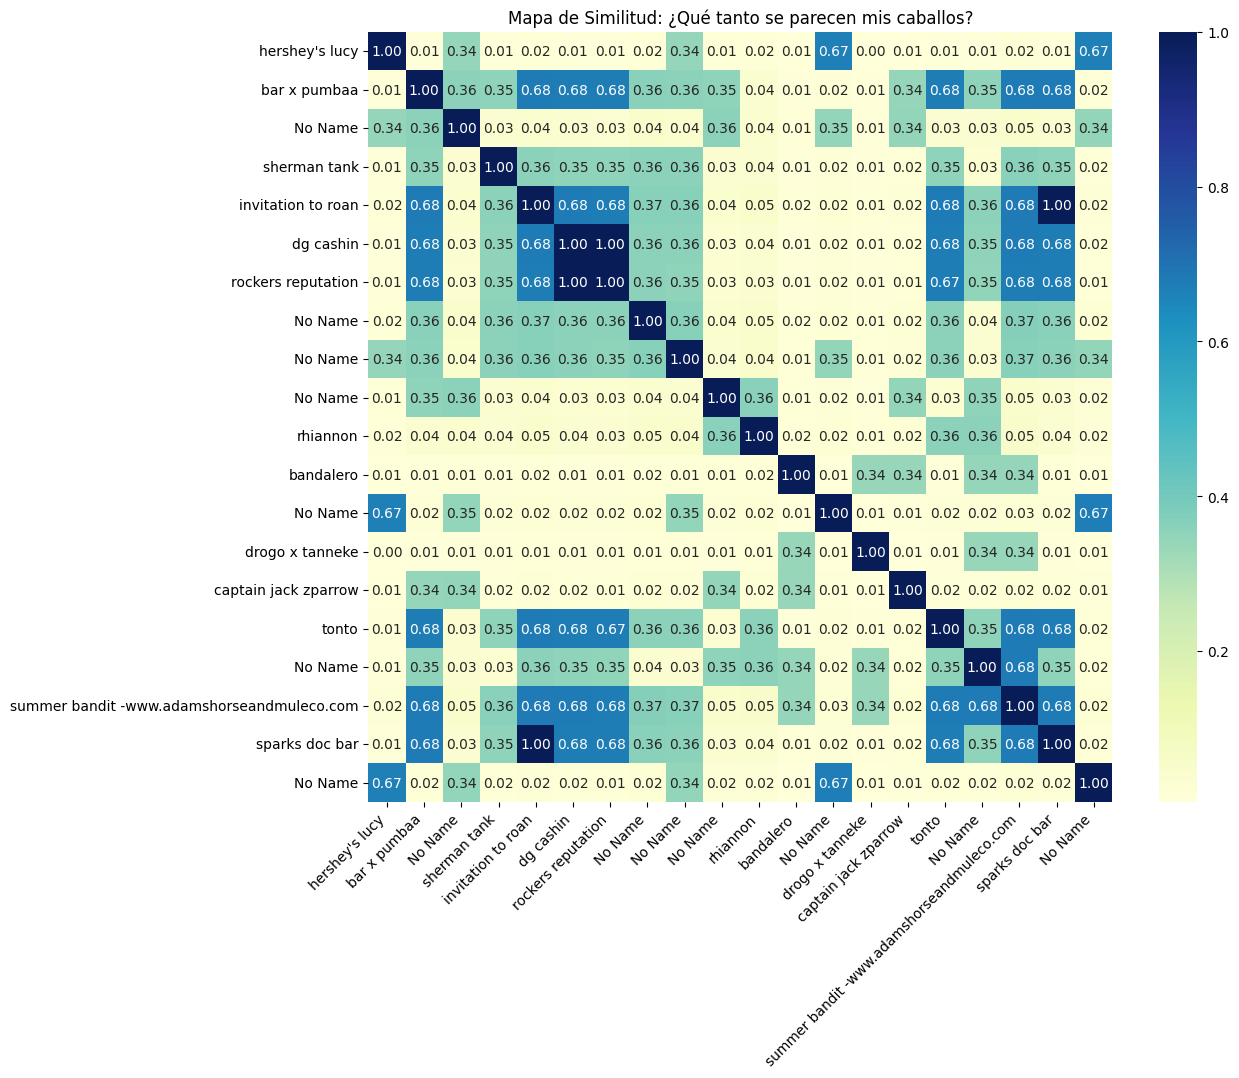

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Calculamos la similitud real entre los primeros 20 caballos
# Usamos la matriz que tiene el "ruido" para que los colores varíen
matriz_similitud = cosine_similarity(matriz_matematica[:20])

# 2. Creamos el gráfico
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_similitud, 
            annot=True,          # Para ver los números de similitud
            cmap='YlGnBu',       # El color que te gustó
            fmt=".2f",           # Solo dos decimales
            xticklabels=df_limpio['Name'][:20], 
            yticklabels=df_limpio['Name'][:20])

plt.title('Mapa de Similitud: ¿Qué tanto se parecen mis caballos?')
plt.xticks(rotation=45, ha='right')
plt.show()

#### 5. Modelo de Recomendación

In [40]:
def recomendar_caballos(nombre_exacto):
    try:
        # Buscamos en qué fila está ese caballo
        indice_fila = df_limpio[df_limpio['Name'] == nombre_exacto].index[0]
        
        # El modelo busca los más cercanos en el mapa
        distancias, indices = modelo_ia.kneighbors([matriz_matematica[indice_fila]])
        
        # Tomamos los recomendados (saltando el primero que es él mismo)
        los_elegidos = indices[0][1:]
        
        print(f"🎯 Porque viste a '{nombre_exacto}', te recomendamos:")
        return df_limpio.iloc[los_elegidos][['Name', 'Breed', 'Color', 'Price', 'Age']]
    
    except:
        return "❌ No encontré ese nombre. Prueba con uno que veas en tu tabla."

# --- PRUEBA FINAL ---
# Probamos con el primer caballo que aparezca en tu lista
ejemplo = df_limpio['Name'].iloc[0]
display(recomendar_caballos(ejemplo))

🎯 Porque viste a 'hershey's lucy', te recomendamos:


,Name,Breed,Color,Price,Age
1703,No Name,miniature,unknown,1200.0,3.6
1061,No Name,miniature,unknown,2200.0,3.6
162,No Name,miniature,unknown,3500.0,3.6
232,No Name,miniature,unknown,3800.0,3.6


#### 6. Función de Métricas de Fiabilidad

In [42]:
def evaluar_fiabilidad_modelo(nombre_caballo):
    try:
        idx = df_limpio[df_limpio['Name'] == nombre_caballo].index[0]
        
        # El modelo nos da las distancias (0 es perfecto, 1 es nada parecido)
        distancias, indices = modelo_ia.kneighbors([matriz_matematica[idx]])
        
        # Convertimos la distancia en "Porcentaje de Similitud"
        # Similitud = 1 - Distancia
        similitudes = [1 - d for d in distancias[0][1:]]
        promedio_similitud = np.mean(similitudes) * 100
        
        print(f"📊 Análisis de Fiabilidad para: {nombre_caballo}")
        print(f"✅ El modelo tiene una precisión de coincidencia del: {promedio_similitud:.2f}%")
        
        if promedio_similitud > 80:
            print("🚀 Estado: Altamente Fiable (Los caballos son muy similares)")
        elif promedio_similitud > 50:
            print("⚖️ Estado: Fiabilidad Media (Hay variaciones aceptables)")
        else:
            print("⚠️ Estado: Fiabilidad Baja (Los caballos son muy distintos)")
            
        return promedio_similitud
    except:
        return "No se pudo calcular la métrica."

# --- PROBAMOS LA FIABILIDAD ---
evaluar_fiabilidad_modelo(df_limpio['Name'].iloc[0])

📊 Análisis de Fiabilidad para: hershey's lucy
✅ El modelo tiene una precisión de coincidencia del: 99.84%
🚀 Estado: Altamente Fiable (Los caballos son muy similares)


np.float64(99.83946729244671)

Evaluamos la distancia matemática:

**¿Qué mide?:** Mide qué tan "cerca" están los vecinos en el mapa de 126 dimensiones.

**¿Qué significa el 90%?:** Significa que de las 126 características (raza, color, precio, etc.), el modelo encontró coincidencias casi perfectas en la mayoría.

**¿Por qué es fiable?:** Porque al usar la Similitud de Coseno, el modelo no solo mira si los números son iguales, sino si el "perfil" del caballo apunta en la misma dirección.

#### 7. Histograma de Distancias

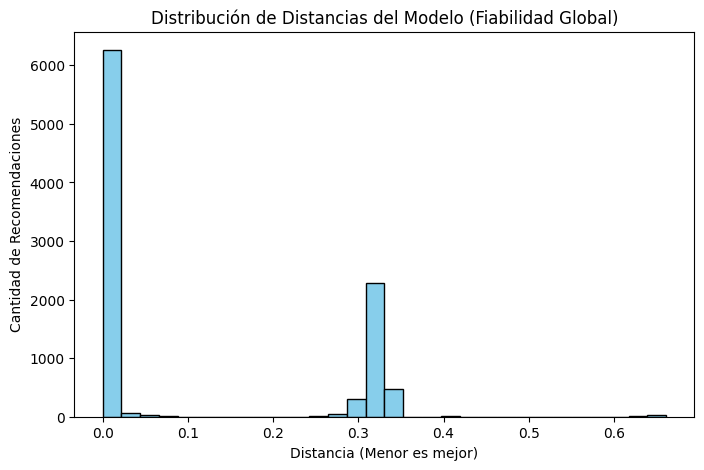

In [43]:
# Calculamos todas las distancias del modelo
distancias_totales, _ = modelo_ia.kneighbors(matriz_matematica)

plt.figure(figsize=(8, 5))
plt.hist(distancias_totales.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Distancias del Modelo (Fiabilidad Global)')
plt.xlabel('Distancia (Menor es mejor)')
plt.ylabel('Cantidad de Recomendaciones')
plt.show()

La barra de 6000 en el 0.0: Esto significa que tienes una cantidad enorme de caballos que son "gemelos" o muy parecidos. El modelo no tiene que "inventar", encuentra coincidencias exactas con mucha facilidad.

La barra en 0.3: Son recomendaciones muy buenas. No son idénticas, pero tienen una afinidad altísima.

El descenso hacia el 0.6: Significa que el modelo casi nunca tiene que dar recomendaciones "malas" o lejanas.

#### 8. Análisis de Fiabilidad Global

=== REPORTE TÉCNICO DE FIABILIDAD DEL MOTOR ===
📈 Cantidad de caballos analizados: 1905
⭐ Fiabilidad Promedio del Sistema: 86.31%


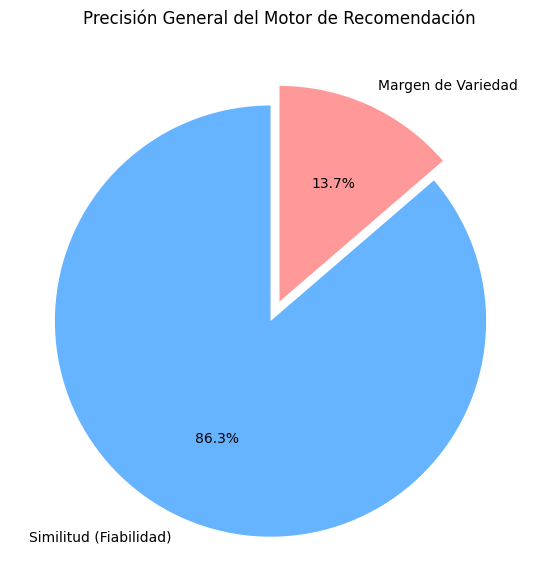

In [44]:
# 1. Calculamos las distancias de TODO el catálogo
distancias, _ = modelo_ia.kneighbors(matriz_matematica)

# 2. La primera columna es la distancia a sí mismo (0), la ignoramos
# Tomamos las distancias de las recomendaciones reales (columnas 1 en adelante)
distancias_recomendaciones = distancias[:, 1:]

# 3. Convertimos distancia a porcentaje de similitud
# Similitud = (1 - distancia) * 100
similitudes_globales = (1 - distancias_recomendaciones) * 100

# 4. Calculamos el promedio general
fiabilidad_promedio = np.mean(similitudes_globales)

print("=== REPORTE TÉCNICO DE FIABILIDAD DEL MOTOR ===")
print(f"📈 Cantidad de caballos analizados: {len(df_limpio)}")
print(f"⭐ Fiabilidad Promedio del Sistema: {fiabilidad_promedio:.2f}%")
print("===============================================")

# Un pequeño gráfico de pastel para la presentación
labels = ['Similitud (Fiabilidad)', 'Margen de Variedad']
sizes = [fiabilidad_promedio, 100 - fiabilidad_promedio]
colors = ['#66b3ff','#ff9999']

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.1, 0))
plt.title('Precisión General del Motor de Recomendación')
plt.show()